In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
edgelist = pd.read_csv("out.arenas-pgp", sep=" ")
edgelist.drop(['unweighted'], axis=1, inplace=True)
edgelist.rename(columns={'%': 'Source', 'sym': 'Target'}, inplace=True)
edgelist.head()

,Source,Target
%,24316,10680.0
1,2,NaN
2,617,NaN
3,4,NaN
3,5,NaN


In [3]:
edgelist.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24317 entries, % to 10620
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Source  24317 non-null  int64  
 1   Target  1 non-null      float64
dtypes: float64(1), int64(1)
memory usage: 569.9+ KB


In [4]:
p = 0.03 # Activation Probability used in independent cascade model
k = 5    # Seed Size
max_t = 1000  # Max Iterations

In [5]:
hamsterster = nx.read_edgelist("out.arenas-pgp", comments = '%')

In [6]:
num_nodes = hamsterster.number_of_nodes()
num_edges = hamsterster.number_of_edges()
num_nodes, num_edges

(10680, 24316)

In [7]:
def neighbors(idx):
    return list(dict(hamsterster.adjacency())[str(int(idx))])

def len_second_neighbors(idx, neighbor_list=None):
    if neighbor_list is None:
        neighbor_list = neighbors(idx)
    l = []
    for t in neighbor_list:
        l += neighbors(t)
    if str(idx) in l:
        return len(l) - 1
    else:
        return len(l)

## Fitness

In [8]:
# Equation 13
def get_seed_set(vec, sol_size):
    try:
        return np.argsort(vec[0, :])[- sol_size - 1:-1] + 1
    except IndexError:
        return np.argsort(vec)[-sol_size-1:-1] + 1

def fitness(position_vec, sol_size):
    wcj = []
    if position_vec.shape[0] != 1:
        position_vec = np.reshape(position_vec, newshape=(1, -1))
    seed_set = get_seed_set(position_vec, sol_size)
    for seed in seed_set:
        nb_list = neighbors(seed)
        dj = len(nb_list)
        Ivj = p * dj * (dj + len_second_neighbors(seed, nb_list) * p)
        wcj.append(Ivj)

    return -1* np.sum(wcj * np.log(wcj/np.sum(wcj))) / np.sum(wcj) # Entropy

## Wolves

In [9]:
# Algorithm 3
def init_wolf(graph):
    X = np.random.random((1, len(graph))) * list(dict(graph.degree()).values())
#     X /= np.sum(X, axis=1)[:, None]
    return X

def init_omega_wolves(num, graph):
    X = np.random.random((num, len(graph))) * list(dict(graph.degree()).values())
#     X /= np.sum(X, axis=1)[:, None]
    return X

In [10]:
# Equation 7, 8, 9
def update_random_constant_vectors(r1, r2, t):    
    a = 2. - 2. * t / max_t
    A = 2 * r1 * a - a
    C = 2 * r2
    return a, A, C

In [11]:
# Algorithm 4
def update_omega_wolf(A, C, V, Xi, alpha, beta, delta):
    Y1 = alpha - A[0, :] * np.abs(C[0, :] * alpha - Xi)
    Y2 = alpha - A[1, :] * np.abs(C[1, :] * delta - Xi)
    Y3 = alpha - A[2, :] * np.abs(C[2, :] * alpha - Xi)
    Xnew = (Y1 + Y2 + Y3)/3
    return Xnew
    
def update_position_vector(A, C, V, alpha, beta, delta, omega_wolves):
    for i in range(omega_wolves.shape[0]):
        omega_wolves[i, :] = update_omega_wolf(A, C, V, omega_wolves[i, :], alpha, beta, delta)
    return omega_wolves

In [12]:
def init_primary_pack(V, sol_size):
    alpha = init_wolf(V)
    beta = init_wolf(V)
    delta = init_wolf(V)
    
    alpha_score = fitness(alpha, sol_size)
    beta_score = fitness(beta, sol_size)
    delta_score = fitness(delta, sol_size)
    if delta_score > alpha_score:
        delta, alpha = alpha, delta
    if delta_score > beta_score:
        delta, beta = beta, delta
    if beta_score > alpha_score:
        beta, alpha = alpha, beta
    return alpha, beta, delta

def update_pack(alpha, beta, delta, omega_wolves, sol_size):
    alpha_score = fitness(alpha, sol_size)
    beta_score = fitness(beta, sol_size)
    delta_score = fitness(delta, sol_size)
    for i in range(omega_wolves.shape[0]):
        omega_score = fitness(omega_wolves[i:i+1], sol_size)
        if omega_score > alpha_score:
            temp = delta
            delta = beta
            beta = alpha
            alpha = omega_wolves[i, :]
            omega_wolves[i, :] = temp
            del temp
        elif omega_score > beta_score:
            temp = delta
            delta = beta
            beta = omega_wolves[i, :]
            omega_wolves[i, :] = temp
            del temp
        elif omega_score > delta_score:
            delta, omega_wolves[i, :] = omega_wolves[i, :], delta
    
    return alpha, beta, delta, omega_wolves

## Algorithm

Subgrah Selected with 6451 nodes
Initialized 50 wolves
Iteration 0/200	Fitness: [1.454506432486933, 2.0358990569266475, 2.450604579511019]
Iteration 1/200	Fitness: [1.4246015070008378, 2.0810678052308837, 2.1523844291055534]
Iteration 2/200	Fitness: [2.062250852715741, 2.1072147190358046, 2.1527142795213625]
Iteration 3/200	Fitness: [1.8945873011788288, 1.8945873011788288, 1.8560259758956654]
Iteration 4/200	Fitness: [1.8334023484760642, 1.8334023484760642, 2.02000966177728]
Iteration 5/200	Fitness: [2.0548546485547483, 2.0548546485547483, 2.0548546485547483]
Iteration 6/200	Fitness: [2.155250297477901, 2.155250297477901, 2.155250297477901]
Iteration 7/200	Fitness: [2.1602432300519094, 2.1602432300519094, 2.1602432300519094]
Iteration 8/200	Fitness: [2.0595113790804214, 1.923314026315078, 1.923314026315078]
Iteration 9/200	Fitness: [1.8776608158047072, 1.8834533198886467, 1.8845684198191075]
Iteration 10/200	Fitness: [1.893099056396684, 1.884568419819108, 1.9344336313345172]
Iteration 

Iteration 95/200	Fitness: [1.769607315943435, 1.769607315943435, 1.769607315943435]
Iteration 96/200	Fitness: [1.769607315943435, 1.769607315943435, 1.769607315943435]
Iteration 97/200	Fitness: [1.769607315943435, 1.769607315943435, 1.769607315943435]
Iteration 98/200	Fitness: [1.769607315943435, 1.769607315943435, 1.769607315943435]
Iteration 99/200	Fitness: [1.769607315943435, 1.769607315943435, 1.769607315943435]
Iteration 100/200	Fitness: [1.769607315943435, 1.769607315943435, 1.769607315943435]
Iteration 101/200	Fitness: [1.769607315943435, 1.769607315943435, 1.769607315943435]
Iteration 102/200	Fitness: [1.7830267975482856, 1.7830267975482856, 1.7830267975482856]
Iteration 103/200	Fitness: [1.7830267975482856, 1.7830267975482856, 1.7830267975482856]
Iteration 104/200	Fitness: [1.7830267975482856, 1.7830267975482856, 1.7830267975482856]
Iteration 105/200	Fitness: [1.783026797548286, 1.783026797548286, 1.783026797548286]
Iteration 106/200	Fitness: [1.7830267975482859, 1.78302679754

Iteration 189/200	Fitness: [1.72749721528837, 1.72749721528837, 1.72749721528837]
Iteration 190/200	Fitness: [1.72749721528837, 1.72749721528837, 1.72749721528837]
Iteration 191/200	Fitness: [1.72749721528837, 1.72749721528837, 1.72749721528837]
Iteration 192/200	Fitness: [1.72749721528837, 1.72749721528837, 1.72749721528837]
Iteration 193/200	Fitness: [1.72749721528837, 1.72749721528837, 1.72749721528837]
Iteration 194/200	Fitness: [1.72749721528837, 1.72749721528837, 1.72749721528837]
Iteration 195/200	Fitness: [1.72749721528837, 1.72749721528837, 1.72749721528837]
Iteration 196/200	Fitness: [1.72749721528837, 1.72749721528837, 1.72749721528837]
Iteration 197/200	Fitness: [1.72749721528837, 1.72749721528837, 1.72749721528837]
Iteration 198/200	Fitness: [1.72749721528837, 1.72749721528837, 1.72749721528837]
Iteration 199/200	Fitness: [1.72749721528837, 1.72749721528837, 1.72749721528837]
Iteration 200/200	Fitness: [1.72749721528837, 1.72749721528837, 1.72749721528837]


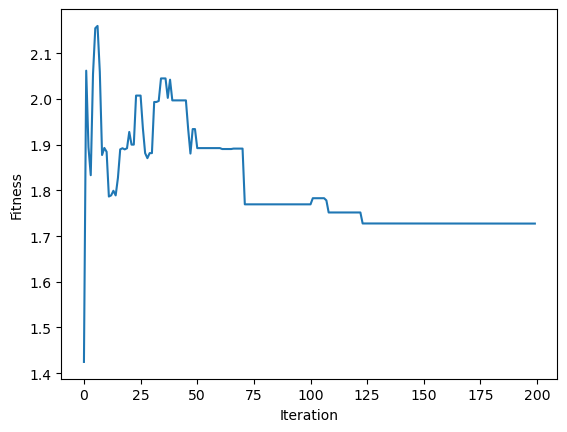

In [13]:
def GWO(pack_size, graph, sol_size=3, max_iters=100, loss_fn=fitness):
    assert pack_size > 3, "Pack Size should be at least 4"
    losses = []

    # V' selection
    degree = hamsterster.degree()
    to_keep = [n[0] for n in degree if n[1] != 1]
    V = hamsterster.subgraph(to_keep)
    print("Subgrah Selected with", len(V), "nodes")

    alpha, beta, delta = init_primary_pack(V, sol_size)
    omega_wolves = init_omega_wolves(pack_size - 3, V)
    fitness_vals= []
    iter_vals = []
    print("Initialized", pack_size, "wolves")
    print("Iteration {}/{}".format(0, max_iters), end="\t")
    alpha, beta, delta, omega_wolves = update_pack(alpha, beta, delta, omega_wolves, sol_size)
    loss = [loss_fn(alpha, sol_size), loss_fn(beta, sol_size), loss_fn(delta, sol_size)]
    losses.append(loss)
    print("Fitness:", loss)
    
    r1 = np.random.random((3, len(V)))
    r2 = np.random.random((3, len(V)))
    
    for t in range(max_iters):
        print("Iteration {}/{}".format(t + 1, max_iters), end="\t")
        a, A, C = update_random_constant_vectors(r1, r2, t)
        
        omega_wolves = update_position_vector(A, C, V, alpha, beta, delta, omega_wolves)
        alpha, beta, delta, omega_wolves = update_pack(alpha, beta, delta, omega_wolves, sol_size)
        
        fitness_val =fitness(alpha,sol_size)
        fitness_vals.append(fitness_val)
        iter_vals.append(t)
        
        loss = [loss_fn(alpha, sol_size), loss_fn(beta, sol_size), loss_fn(delta, sol_size)]
        losses.append(loss)
        print("Fitness:", loss)
    plt.plot(iter_vals,fitness_vals)
    plt.xlabel("Iteration")
    plt.ylabel("Fitness")
    plt.show()
    return [alpha, beta, delta, omega_wolves], np.array(losses)

wolves, losses = GWO(50, hamsterster, 40, 200)

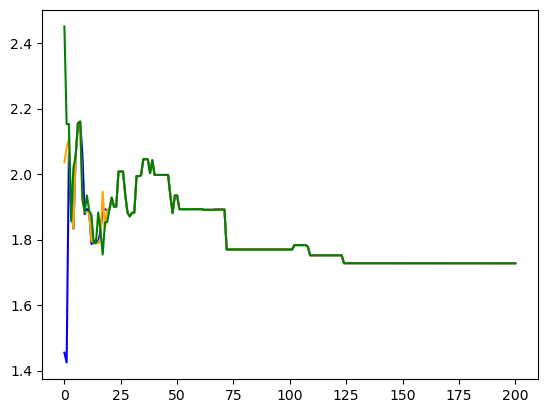

In [18]:
plt.plot(losses[:, 0],color='blue')
plt.plot(losses[:, 1],color='orange')
plt.plot(losses[:, 2],color='green')
plt.show()